# Introduction
The purpose of this notebook is to prove that it's possible to perform transfer learning on your own architecture, using your own dataset, without having to go through some [crazy scripting hoops](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/image_retraining/retrain.py).

[Google's transfer learning tutorial](https://www.tensorflow.org/tutorials/image_retraining) is good at convincing you that transfer learning is possible, but it:  
1.  Doesn't really allow you to change the underlying architecture very easily,  
2.  Goes through clever intermediate value caching, which is super-performant, but also puts a large code base between their example and our purposes, and  
3.  Isn't something I wrote, so it's not something I understand intuitively yet.

Let's fix the above problems.  
Let's train an MNIST model on the first eight digits (0-7), then use transfer learning to train a last layer that can predict between last two (8 and 9).

See, e.g., [Deep MNIST for Experts](https://www.tensorflow.org/get_started/mnist/pros#build_a_multilayer_convolutional_network) for the general architecture that I'll be using.

In [1]:
import tensorflow as tf

/home/human/miniconda3/envs/archform/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Loading the MNIST Data
`TensorFlow` provides a loader for MNIST, but it doesn't easily let us separate the data into digits 0-7 and 8 & 9.  
Accordingly, let's [use `keras` instead](https://keras.io/datasets/#mnist-database-of-handwritten-digits).

In [2]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

(array([ 5923.,  6742.,  5958.,  6131.,  5842.,  5421.,  5918.,  6265.,
         5851.,  5949.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

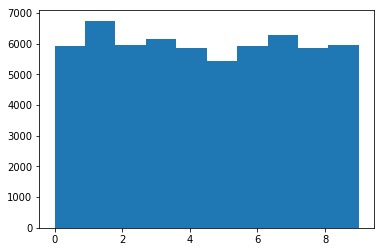

In [4]:
plt.hist(y_train, bins=10)

Ok excellent, the dataset is already roughly balanced between classes.

Keep in mind that we'll be peeling off the last two classes, `8` and `9`, into their own dataset.

Let's define a helper function that to help us separate out only the digits we want from the mixed entire dataset.

In [5]:
def getDigitsFromDataset(digits, x, y):
    """
    Given an iterable of digits,
    return the portion of x and y that contain
    those digits.
    """
    mask = np.zeros_like(y, dtype=bool)
    for digit in digits:
        mask += (y == digit)
        
    x = x[mask]
    y = y[mask]
    
    return x, y

Let's adopt a naming system that will help us keep what we're trying to do straight:  
`base` will refer to the dataset containing the digits `0` through `7`.  
`transfer` will refer to the dataset containing the digits `8` and `9`.

In [6]:
x_train_base, y_train_base = getDigitsFromDataset([*range(8)], x_train, y_train)

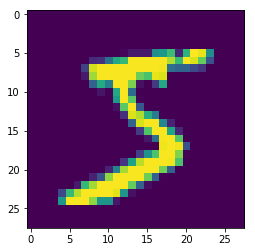

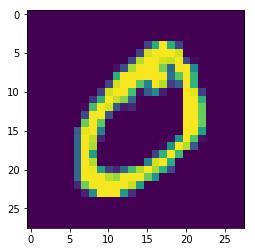

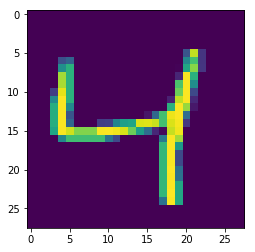

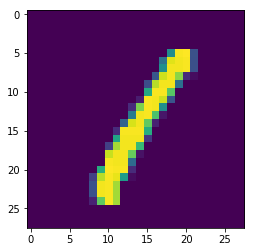

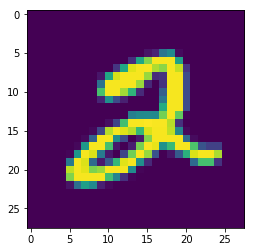

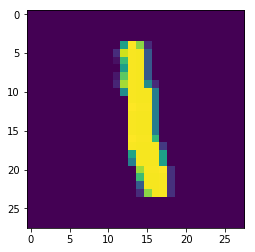

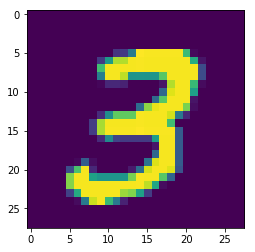

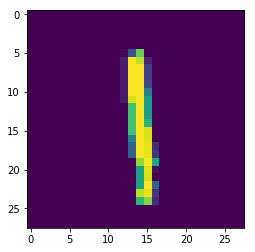

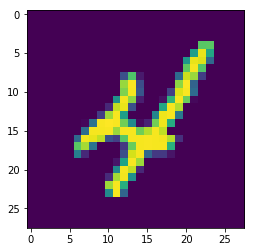

In [7]:
for i in range(9):
    plt.imshow(x_train_base[i])
    plt.show()

In [8]:
x_test_base, y_test_base = getDigitsFromDataset([*range(8)], x_test, y_test)

Now that we have the train / test split for our `base` dataset, let's do the same for our `transfer` dataset.

In [9]:
x_train_transfer, y_train_transfer = getDigitsFromDataset([8, 9], x_train, y_train)

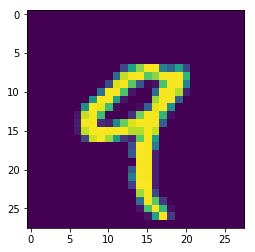

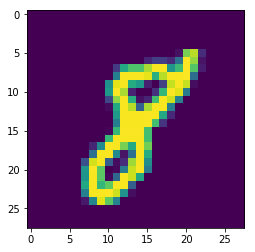

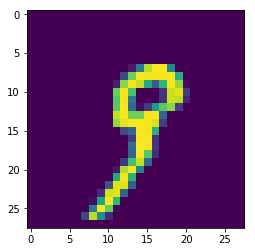

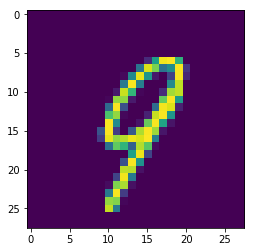

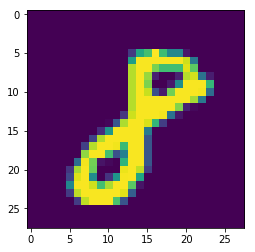

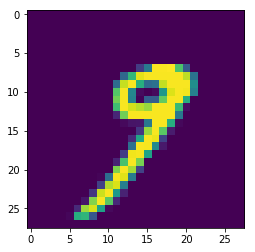

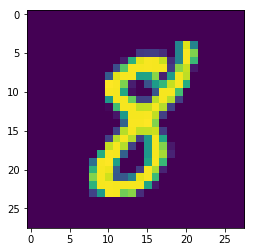

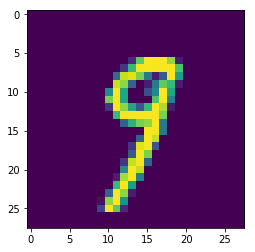

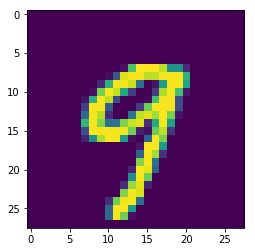

In [10]:
for i in range(9):
    plt.imshow(x_train_transfer[i])
    plt.show()

In [11]:
x_test_transfer, y_test_transfer = getDigitsFromDataset([8,9], x_test, y_test)

### Graph Definition
This is going to mostly be a sequential model, except that it's going to fork at the end into two final layers, loss functions, accuracy calculations, and optimizers.

We'll use one of the forks to train the whole model on digits `0` through `7`, and then we'll use the other fork to train only a single layer on the digits `8` and `9`.

To do this, let's make use of `TensorFlow`'s `variable_scope`, so that we can easily separate `base` from `transfer` in generating lists of trainable variables to pass to our optimizer's `minimize()` method.

Additionally, since we want to be able to train the `base` and `transfer` `variable_scope`s separately, we're also going to define separate loss functions, optimizers, and accuracy metrics.

In [12]:
x = tf.placeholder(tf.float32, shape=[None, 28, 28], name="inputs")

### Base Model
with tf.variable_scope("base"):
    y_base = tf.placeholder(tf.float32, shape=[None, 8], name="labels")

    # Reshape input
    res = tf.reshape(x, shape=[-1, 28, 28, 1], name="reshape")

    # Conv
    with tf.variable_scope("conv1"):
        c1 = tf.contrib.layers.conv2d(inputs=res,
                                  num_outputs=32,
                                  kernel_size=5,
                                  stride=1,
                                  padding='SAME',
                                  activation_fn=tf.nn.relu,
                                  weights_initializer=tf.initializers.truncated_normal(stddev=0.1),
                                  biases_initializer=tf.initializers.constant(0.1))
        
    # Pool
    mp1 = tf.nn.max_pool(c1, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME', name="maxpool1")

    # Conv
    with tf.variable_scope("conv2"):
        c2 = tf.contrib.layers.conv2d(inputs=mp1,
                                  num_outputs=64,
                                  kernel_size=5,
                                  stride=1,
                                  padding='SAME',
                                  activation_fn=tf.nn.relu,
                                  weights_initializer=tf.initializers.truncated_normal(stddev=0.1),
                                  biases_initializer=tf.initializers.constant(0.1))
    # Pool
    mp2 = tf.nn.max_pool(c2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1], padding='SAME', name="maxpool2")

    # Flatten
    flat = tf.layers.flatten(mp2, name="flatten")

    # FC
    with tf.variable_scope("dense1"):
        fc1 = tf.contrib.layers.fully_connected(inputs=flat,
                                      num_outputs=1024,
                                      activation_fn=tf.nn.relu,
                                      weights_initializer=tf.initializers.truncated_normal(stddev=0.1),
                                      biases_initializer=tf.initializers.constant(0.1))

    # Drop
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    dr = tf.nn.dropout(fc1, keep_prob, name="bottleneck")

    # FC
    with tf.variable_scope("logits"):
        fc2_base = tf.contrib.layers.fully_connected(inputs=dr,
                                      num_outputs=8,
                                      activation_fn=None,
                                      weights_initializer=tf.initializers.truncated_normal(stddev=0.1),
                                      biases_initializer=tf.initializers.constant(0.1))
    
    #### Model Evaluation
    
    with tf.variable_scope("cross_entropy"):
        cross_entropy_base = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_base, logits=fc2_base))
    
    base_vars = [var for var in tf.trainable_variables() if var.name.startswith("base")]
    
    with tf.variable_scope("Adam"):
        train_step_base = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy_base, var_list=base_vars)
    
    with tf.variable_scope("correct_prediction"):
        correct_prediction_base = tf.equal(tf.argmax(fc2_base, 1), tf.argmax(y_base, 1))
    
    with tf.variable_scope("accuracy"):
        accuracy_base = tf.reduce_mean(tf.cast(correct_prediction_base, tf.float32))
        

### Transfer Fork
with tf.variable_scope("transfer"):
    y_trans = tf.placeholder(tf.float32, shape=[None, 2], name="labels")
    
    # FC
    with tf.variable_scope("logits"):
        fc2_trans = tf.contrib.layers.fully_connected(inputs=dr,
                                      num_outputs=2,
                                      activation_fn=None,
                                      weights_initializer=tf.initializers.truncated_normal(stddev=0.1),
                                      biases_initializer=tf.initializers.constant(0.1))
    
    #### Model Evaluation
    with tf.variable_scope("cross_entropy"):
        cross_entropy_trans = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_trans, logits=fc2_trans))
    
    trans_vars = [var for var in tf.trainable_variables() if var.name.startswith("transfer")]
    
    with tf.variable_scope("Adam"):
        train_step_trans = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy_trans, var_list=trans_vars)
        
    with tf.variable_scope("correct_prediction"):
        correct_prediction_trans = tf.equal(tf.argmax(fc2_trans, 1), tf.argmax(y_trans, 1))
    
    with tf.variable_scope("accuracy"):
        accuracy_trans = tf.reduce_mean(tf.cast(correct_prediction_trans, tf.float32))

The architecture we defined above looks like this in `TensorBoard`:  
![Model Architecture](img/graph.png)

Note especially that the **Adam** optimizers here are different.  
Specifically, one trains the "base" variables, and one trains the "transfer" variables.  
Base-training Adam Optimizer:  
![Base-training Adam Optimizer](img/graph_base_highlight.png)  
Transfer-training Adam Optimizer:
![Transfer-training Adam Optimizer](img/graph_trans_highlight.png)

In order to convince ourselves that our `base` training is only updating the model variables in the `base` scope (and similarly that the `transfer` training is only updating the model variables in the `transfer` scope), let's grab everything so that we can display it in `TensorBoard` for inspection.

In [13]:
for v in tf.trainable_variables():
    tf.summary.histogram(v.name, v)

INFO:tensorflow:Summary name base/conv1/Conv/weights:0 is illegal; using base/conv1/Conv/weights_0 instead.
INFO:tensorflow:Summary name base/conv1/Conv/biases:0 is illegal; using base/conv1/Conv/biases_0 instead.
INFO:tensorflow:Summary name base/conv2/Conv/weights:0 is illegal; using base/conv2/Conv/weights_0 instead.
INFO:tensorflow:Summary name base/conv2/Conv/biases:0 is illegal; using base/conv2/Conv/biases_0 instead.
INFO:tensorflow:Summary name base/dense1/fully_connected/weights:0 is illegal; using base/dense1/fully_connected/weights_0 instead.
INFO:tensorflow:Summary name base/dense1/fully_connected/biases:0 is illegal; using base/dense1/fully_connected/biases_0 instead.
INFO:tensorflow:Summary name base/logits/fully_connected/weights:0 is illegal; using base/logits/fully_connected/weights_0 instead.
INFO:tensorflow:Summary name base/logits/fully_connected/biases:0 is illegal; using base/logits/fully_connected/biases_0 instead.
INFO:tensorflow:Summary name transfer/logits/ful

### Batching function


In [14]:
def get_batches(x, y, batch_size=50, num_classes=8):
    '''
    Given a set of features x, and a set of labels y,
    return a generator yields shuffled batch_size tuples of x and y.
    
    Note that this function truncates x and y, if necessary,
    so that it only returns full batches.
    '''
    ## Shuffle x and y on the same index permutation
    permute = np.random.permutation(range(len(x)))
    x = x[permute]
    y = y[permute]
    
    ## Truncate x and y so that no batch is empty
    num_batches = len(x) // batch_size
    x, y = x[:num_batches * batch_size], y[:num_batches * batch_size]
    
    # One-hot encode the labels:
    y = np.eye(num_classes)[y]
    
    for i in range(0, len(x), batch_size):
        yield x[i:i + batch_size], y[i:i + batch_size]

### Train the Base Model
As discussed above, now let's train the base model on digits `0` through `7`.

Later, we will train the final transfer layer to recognize the digits `8` and `9`.

In [15]:
# To keep our summary directories separate
from datetime import datetime

In [16]:
batch_size = 50
epochs = 1

# Define a time-stamped directory in which to keep the TensorBoard data for this run
summaries_dir = "./summaries/" + datetime.now().strftime("%Y%m%d%H%M%S")

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    merged = tf.summary.merge_all()
    base_writer = tf.summary.FileWriter(summaries_dir + '/base', sess.graph)
    
    i = 1
    for e in range(epochs):
        for x_, y_ in get_batches(x_train_base, y_train_base, batch_size):
            if i % 50 == 0:
                train_accuracy, summary = sess.run([accuracy_base, merged],
                    feed_dict={x: x_,
                               y_base: y_,
                               keep_prob: 1.0})
                print('step %d, base training accuracy %g' % (i, train_accuracy))
                base_writer.add_summary(summary, i)
            
            train_step_base.run(
                feed_dict={x: x_,
                           y_base: y_,
                           keep_prob: 0.5})
            i += 1

    y_test_base_oh = np.eye(8)[y_test_base]
    print('base test accuracy %g' % accuracy_base.eval(
        feed_dict={
            x: x_test_base,
            y_base: y_test_base_oh,
            keep_prob: 1.0}))
    
    saver.save(sess, "checkpoints/base.ckpt")

step 50, base training accuracy 0.84
step 100, base training accuracy 0.88
step 150, base training accuracy 0.94
step 200, base training accuracy 0.98
step 250, base training accuracy 0.92
step 300, base training accuracy 0.92
step 350, base training accuracy 0.96
step 400, base training accuracy 0.94
step 450, base training accuracy 0.96
step 500, base training accuracy 0.94
step 550, base training accuracy 1
step 600, base training accuracy 0.98
step 650, base training accuracy 0.94
step 700, base training accuracy 0.98
step 750, base training accuracy 0.94
step 800, base training accuracy 1
step 850, base training accuracy 0.96
step 900, base training accuracy 0.98
step 950, base training accuracy 1
base test accuracy 0.975427


### Sanity Check the Base Model
As of right now, the base model shouldn't know anything about the digits `8` or `9`.

Let's load our trained model, and test the accuracy of the transfer fork on some training examples from the transfer dataset.

In [17]:
y_train_transfer

array([9, 8, 9, ..., 9, 8, 8], dtype=uint8)

Let's abandon the previous indexing.

This allows us to represent the digit `8` as the class `0`, and the digit `9` as the class `1`.

That is, `0` isn't the digit `0`, and `1` isn't the digit `1`.

Otherwise, we would have to do some gymnastics to properly represent what is essentially a binary classification problem.

In [18]:
np.eye(2)[y_train_transfer - 8]

array([[ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.],
       ..., 
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [19]:
np.eye(2)[y_train_transfer - 8].shape

(11800, 2)

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    y_train_transfer_oh = np.eye(2)[y_train_transfer - 8]
    print('transfer accuracy %g' % accuracy_trans.eval(
        feed_dict={
            x: x_train_transfer,
            y_trans: y_train_transfer_oh,
            keep_prob: 1.0}))


INFO:tensorflow:Restoring parameters from checkpoints/base.ckpt
transfer accuracy 0.392034


Well, that's about what we would expect for a totally untrained model.

Let's see if we can't improve that classification by **only** training the `TensorFlow` variables in the `transfer` scope.

In [21]:
batch_size = 50
epochs = 5

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    i = 1
    trans_writer = tf.summary.FileWriter(summaries_dir + '/transfer', sess.graph)
    
    for e in range(epochs):
        for x_, y_ in get_batches(x_train_transfer, y_train_transfer - 8, batch_size, num_classes=2):
            if i % 50 == 0:
                train_accuracy, summary = sess.run([accuracy_trans, merged],
                    feed_dict={x: x_,
                               y_trans: y_,
                               keep_prob: 1.0})
                print('step %d, transfer training accuracy %g' % (i, train_accuracy))
                trans_writer.add_summary(summary, i)
            
            train_step_trans.run(
                feed_dict={x: x_,
                           y_trans: y_,
                           keep_prob: 0.5})
            i += 1

    y_test_transfer_oh = np.eye(2)[y_test_transfer - 8]
    print('transfer test accuracy %g' % accuracy_trans.eval(
        feed_dict={
            x: x_test_transfer,
            y_trans: y_test_transfer_oh,
            keep_prob: 1.0}))
    
    saver.save(sess, "checkpoints/trans.ckpt")

INFO:tensorflow:Restoring parameters from checkpoints/base.ckpt
step 50, transfer training accuracy 0.56
step 100, transfer training accuracy 0.66
step 150, transfer training accuracy 0.78
step 200, transfer training accuracy 0.8
step 250, transfer training accuracy 0.9
step 300, transfer training accuracy 0.92
step 350, transfer training accuracy 0.88
step 400, transfer training accuracy 0.86
step 450, transfer training accuracy 0.96
step 500, transfer training accuracy 0.92
step 550, transfer training accuracy 0.92
step 600, transfer training accuracy 0.98
step 650, transfer training accuracy 0.96
step 700, transfer training accuracy 0.94
step 750, transfer training accuracy 0.98
step 800, transfer training accuracy 0.98
step 850, transfer training accuracy 0.9
step 900, transfer training accuracy 1
step 950, transfer training accuracy 0.94
step 1000, transfer training accuracy 0.96
step 1050, transfer training accuracy 0.96
step 1100, transfer training accuracy 0.96
step 1150, trans

But now, let's check to see that the base model still doesn't know what the digits `8` and `9` are:

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    y_test_transfer_oh = np.eye(8)[y_test_transfer - 8]
    print('base accuracy on transfer digits %g' % accuracy_base.eval(
        feed_dict={
            x: x_test_transfer,
            y_base: y_test_transfer_oh,
            keep_prob: 1.0}))

INFO:tensorflow:Restoring parameters from checkpoints/trans.ckpt
base accuracy on transfer digits 0.0201715


Additionally, the base model actually shouldn't have changed at all.

To confirm this, let's see that the test accuracy on the base digit set is still the same:

In [23]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    y_test_base_oh = np.eye(8)[y_test_base]
    print('base test accuracy %g' % accuracy_base.eval(
        feed_dict={
            x: x_test_base,
            y_base: y_test_base_oh,
            keep_prob: 1.0}))


INFO:tensorflow:Restoring parameters from checkpoints/trans.ckpt
base test accuracy 0.975427


The base test accuracy is the same out to the 6 decimal places we're checking; that's a good sign that training the `transfer`-scoped variables didn't change the original `base` model.

However, let's inspect the variables that we added summaries for in above. 

# Exploring the Variables
Since we've defined summaries for all of the trainable variables, `TensorBoard` allows us to view how the values for these variables are distributed during our operations above.

We've broken the summaries that we've saved into those that occurred during training on the digits `0` through `7` (the "**base**" training), and those that occurred during training on the digits `8` and `9`.

As can be seen the `base`-scoped variables (top 4 rows) only updated during the **base** training (in pink), and the `transfer`-scoped variables (bottom row) only updated during the **transfer** training (in green).

![first variable histogram](img/var_hist_1.png)
![second variable histogram](img/var_hist_2.png)

This lends further credence to the theory that we've successfully trained a transfer learning model from scratch.